In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os.path
from tqdm import tqdm

%matplotlib inline

class FineLane():
    def __init__(self):
        self.width = 1280
        self.height = 720
        
    """fine the Laneline from car camera image"""
    def calibrate_camera(self,force=False):
        """load the file"""
        chessboard_images='./camera_cal/*.jpg'
        """save the file for reusing"""
        dis_matrix_file='distort_mtx.p'
        
        if os.path.isfile(dis_matrix_file) and not force:
            # load camera distortion matrix if already exists
            dist_pickle = pickle.load(open(dis_matrix_file, 'rb'))
            self.camera = {
                'mtx': dist_pickle['mtx'],
                'dist': dist_pickle['dist'],
            }
        else:
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
          # Start calibrating camera
            # prepare object points
            nx, ny = 9, 5
            objp = np.zeros((nx*ny, 3), np.float32)
            objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            objpoints = []  # 3D coord in real world
            imgpoints = []  # 2D coord in image plane

            calibration_img_paths = glob.glob(chessboard_images)
            # use tqdm to display progress bar
            for img_path in tqdm(calibration_img_paths):
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
                if ret == True:
                    objpoints.append(objp)
                    imgpoints.append(corners)

            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                objpoints, imgpoints, img_size, None, None)

            # Save the camera calibration result for later use
            self.camera = {
                'mtx': mtx,
                'dist': dist,
            }
            # Save camera matrix to avoid recalibrating every time
            # run with force=True to force recalibrate
            pickle.dump(self.camera, open(dis_matrix_file, 'wb'))
    def undistort(self,img):
        """Undistort image using camera matrix"""
        assert 'mtx' in self.camera
        assert 'dist' in self.camera
        mtx = self.camera['mtx']
        dist = self.camera['dist']
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist
    def get_bird_eye_transform_matrix(self,reverse=False):
        tls = (563, 470)  # top left source point
        bls = (220, 700)  # bottom left source point
        tld = (300, 300)  # top left destination 
        bld = (300, 720)  # bottom left destination
        
        src = np.float32([
            [tls[0], tls[1]],
            [self.width-tls[0], tls[1]],
            [self.width-bls[0], bls[1]],
            [bls[0], bls[1]]
        ])

        dst = np.float32([
            [tld[0], tld[1]],
            [self.width-tld[0], tld[1]],
            [self.width-tld[0], bld[1]],
            [bld[0], bld[1]],
        ])
        
        if reverse:
            transform_mtx = cv2.getPerspectiveTransform(dst, src)
        else:
            transform_mtx = cv2.getPerspectiveTransform(src, dst)
        return transform_mtx
    def bird_eye_transform(self,img,reverse=False):
        """Change the car camera image into bird eyes view"""
        transform_mtx = self.get_bird_eye_transform_matrix(reverse=reverse)
        shape = (self.width, self.height)
        warped = cv2.warpPerspective(
            img, transform_mtx, shape, flags=cv2.INTER_LINEAR)
        return warped
    def s_magnitude(self, img, s_thresh=(175, 255)):
        """"for the s-channel"""
        hls=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
        s_channel = hls[:,:,2]
        magnitude_binary = np.zeros_like(s_channel)
        magnitude_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        return magnitude_binary
    def l_direction(self,img, sobel_kernel=5, m_thresh=(10, 255),d_thresh=(0.0, 0.75)):
        """find the L channel in HLS color"""
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        l_channel = hls[:,:,1]
         # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Take the absolute value of the x and y gradients
        abs_sobelx=np.abs(sobelx)
        abs_sobely=np.abs(sobely)
        #Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        grad=np.arctan2(abs_sobely, abs_sobelx)
        # 4) Calculate the magnitude 
        mag=np.sqrt(sobelx**2+sobely**2)
        # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scale_factor = np.max(mag)/255
        gradmag = (mag/scale_factor).astype(np.uint8) 
        #get the direction
        binary_output=np.zeros_like(grad)
        binary_output[
            (grad >= d_thresh[0])&(grad <= d_thresh[1])&
            (gradmag >= m_thresh[0])&(gradmag <= m_thresh[1])] = 1
        return binary_output
    def combined_thresholding(self, img):
        """Returns the combined result of all thresholdings"""
        s_mag = self.s_magnitude(img)
        l_dir = self.l_direction(img)
        combined_binary = np.zeros_like(img[:,:,1])
        combined_binary[(s_mag == 1) | (l_dir == 1)] = 1
        return combined_binary 
    def histogram_find_lines(self,binary_warped, visualize=False):
        """get the formulate for the line"""
        width, height = self.width, self.height
        nwindows = 9
        window_height = np.int(height/nwindows)
        
        histogram = np.sum(binary_warped[int(height/2):,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(width/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        windows=[]
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Set the windows on the visualization image (draw later)
            windows.append((win_xleft_low,win_y_low,win_xleft_high,win_y_high))
            windows.append((win_xright_low,win_y_low,win_xright_high,win_y_high))
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        out_img=None
        if visualize:
            # color left/right lines
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # draw window
            for rect in windows:
                tlx, tly, brx, bry = rect
                cv2.rectangle(out_img, (tlx, tly), (brx, bry), (0, 255, 0), 2)
        
        return left_fit, right_fit, out_img


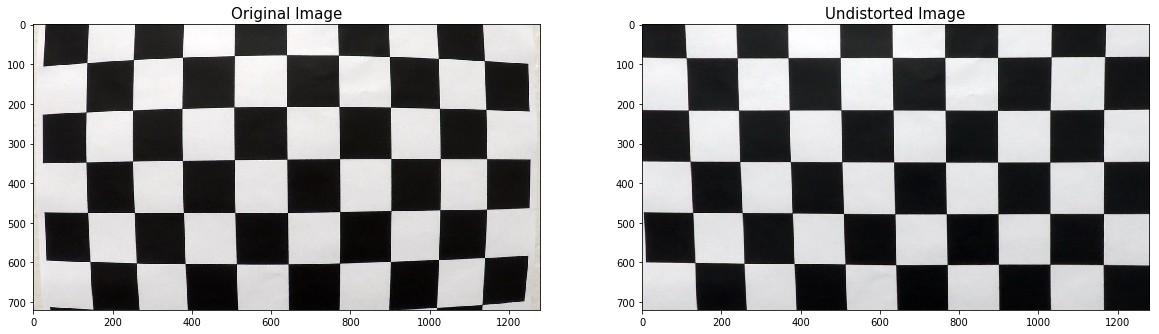

In [40]:
img_size = (720, 1280)
lf = FineLane()
lf.calibrate_camera()
img = cv2.imread('./camera_cal/calibration1.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = lf.undistort(img)
# visualize and save undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=15)
plt.imsave('./output_images/chessboard_original.jpg', rgb)
plt.imsave('./output_images/chessboard_undistort.jpg', undist)



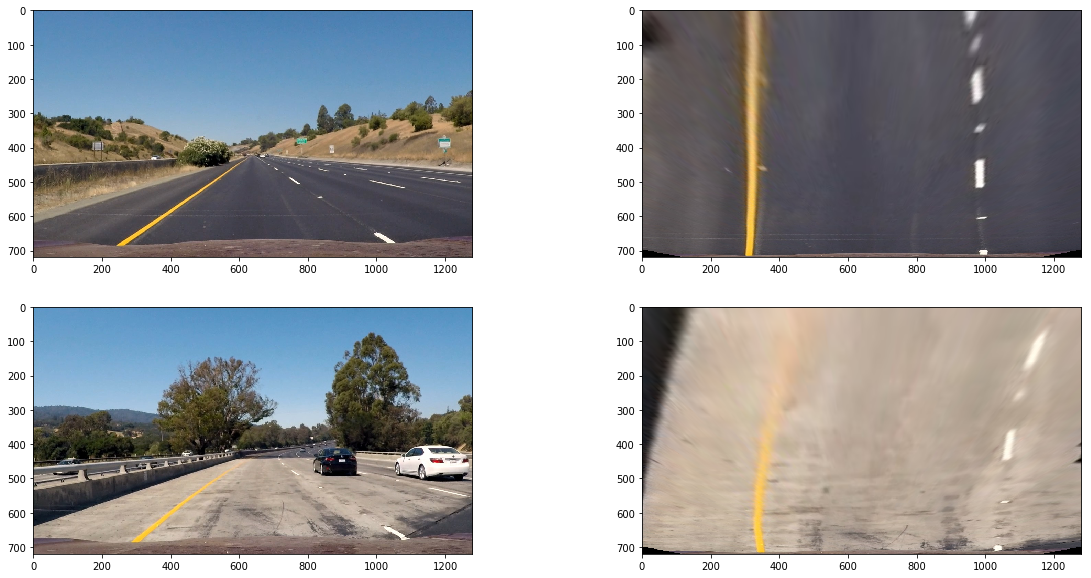

In [41]:
test_images=[
    
    './test_images/straight_lines1.jpg',
    './test_images/test1.jpg'
    
]
f, axarr = plt.subplots(len(test_images), 2, figsize=(20, 5*len(test_images)))
for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    undist = lf.undistort(img)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    warped = lf.bird_eye_transform(rgb)
    
    
    axarr[idx][0].imshow(rgb)
    axarr[idx][1].imshow(warped)
    

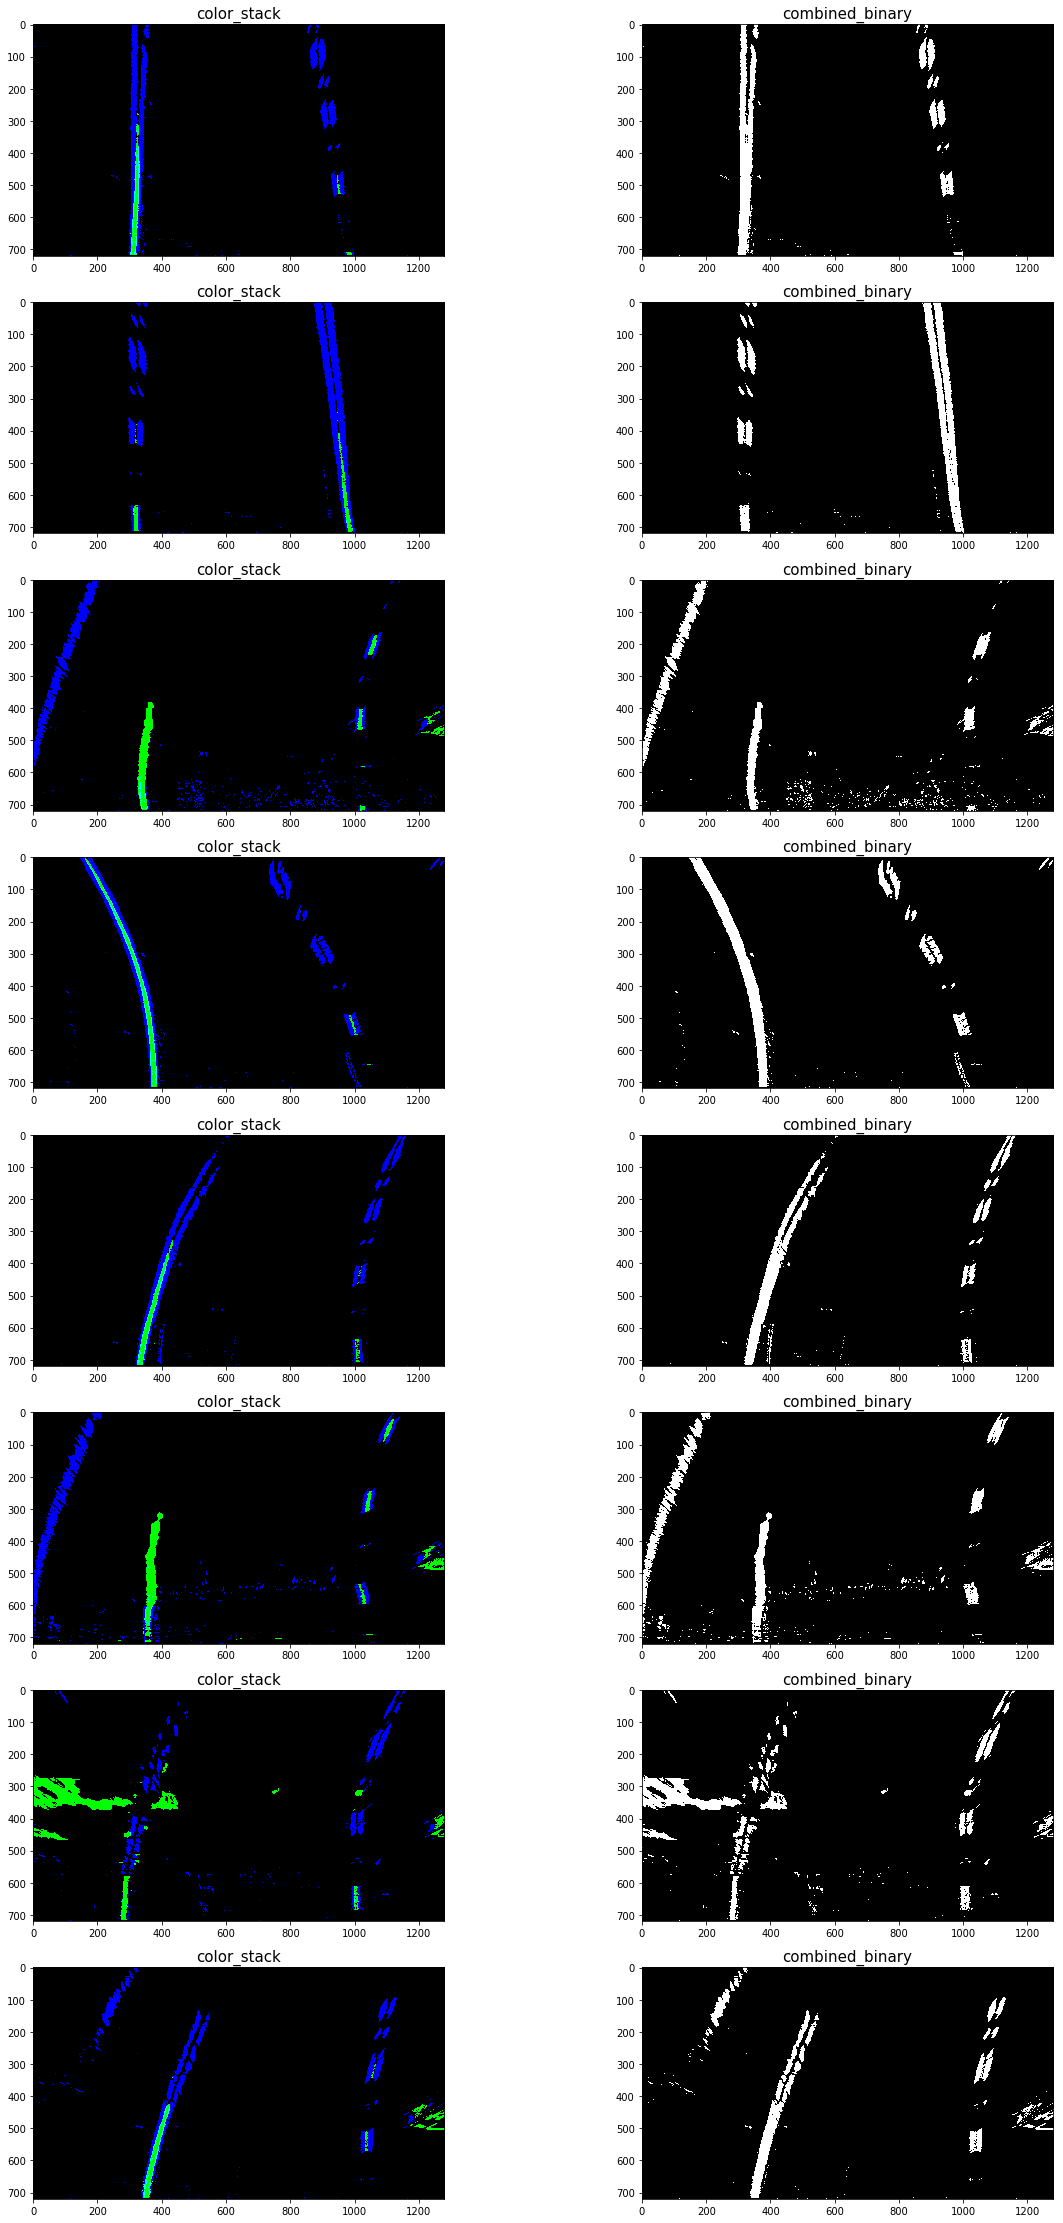

In [42]:
#thershold method
test_images=[
   './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg',
    
]
f, axarr = plt.subplots(len(test_images), 2, figsize=(20, 5*len(test_images)))
for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    undist = lf.undistort(img)
    warped = lf.bird_eye_transform(undist)
    s_mag = lf.s_magnitude(warped)
    l_dir = lf.l_direction(warped)
    
    color_stack = np.dstack(( np.zeros_like(s_mag), s_mag, l_dir))
    combined_binary = lf.combined_thresholding(warped)
        
    # plot the result images
    axarr[idx, 0].imshow(color_stack)
    axarr[idx, 0].set_title('color_stack', fontsize=15)

    axarr[idx, 1].imshow(combined_binary, cmap='gray')
    axarr[idx, 1].set_title('combined_binary', fontsize=15)
    

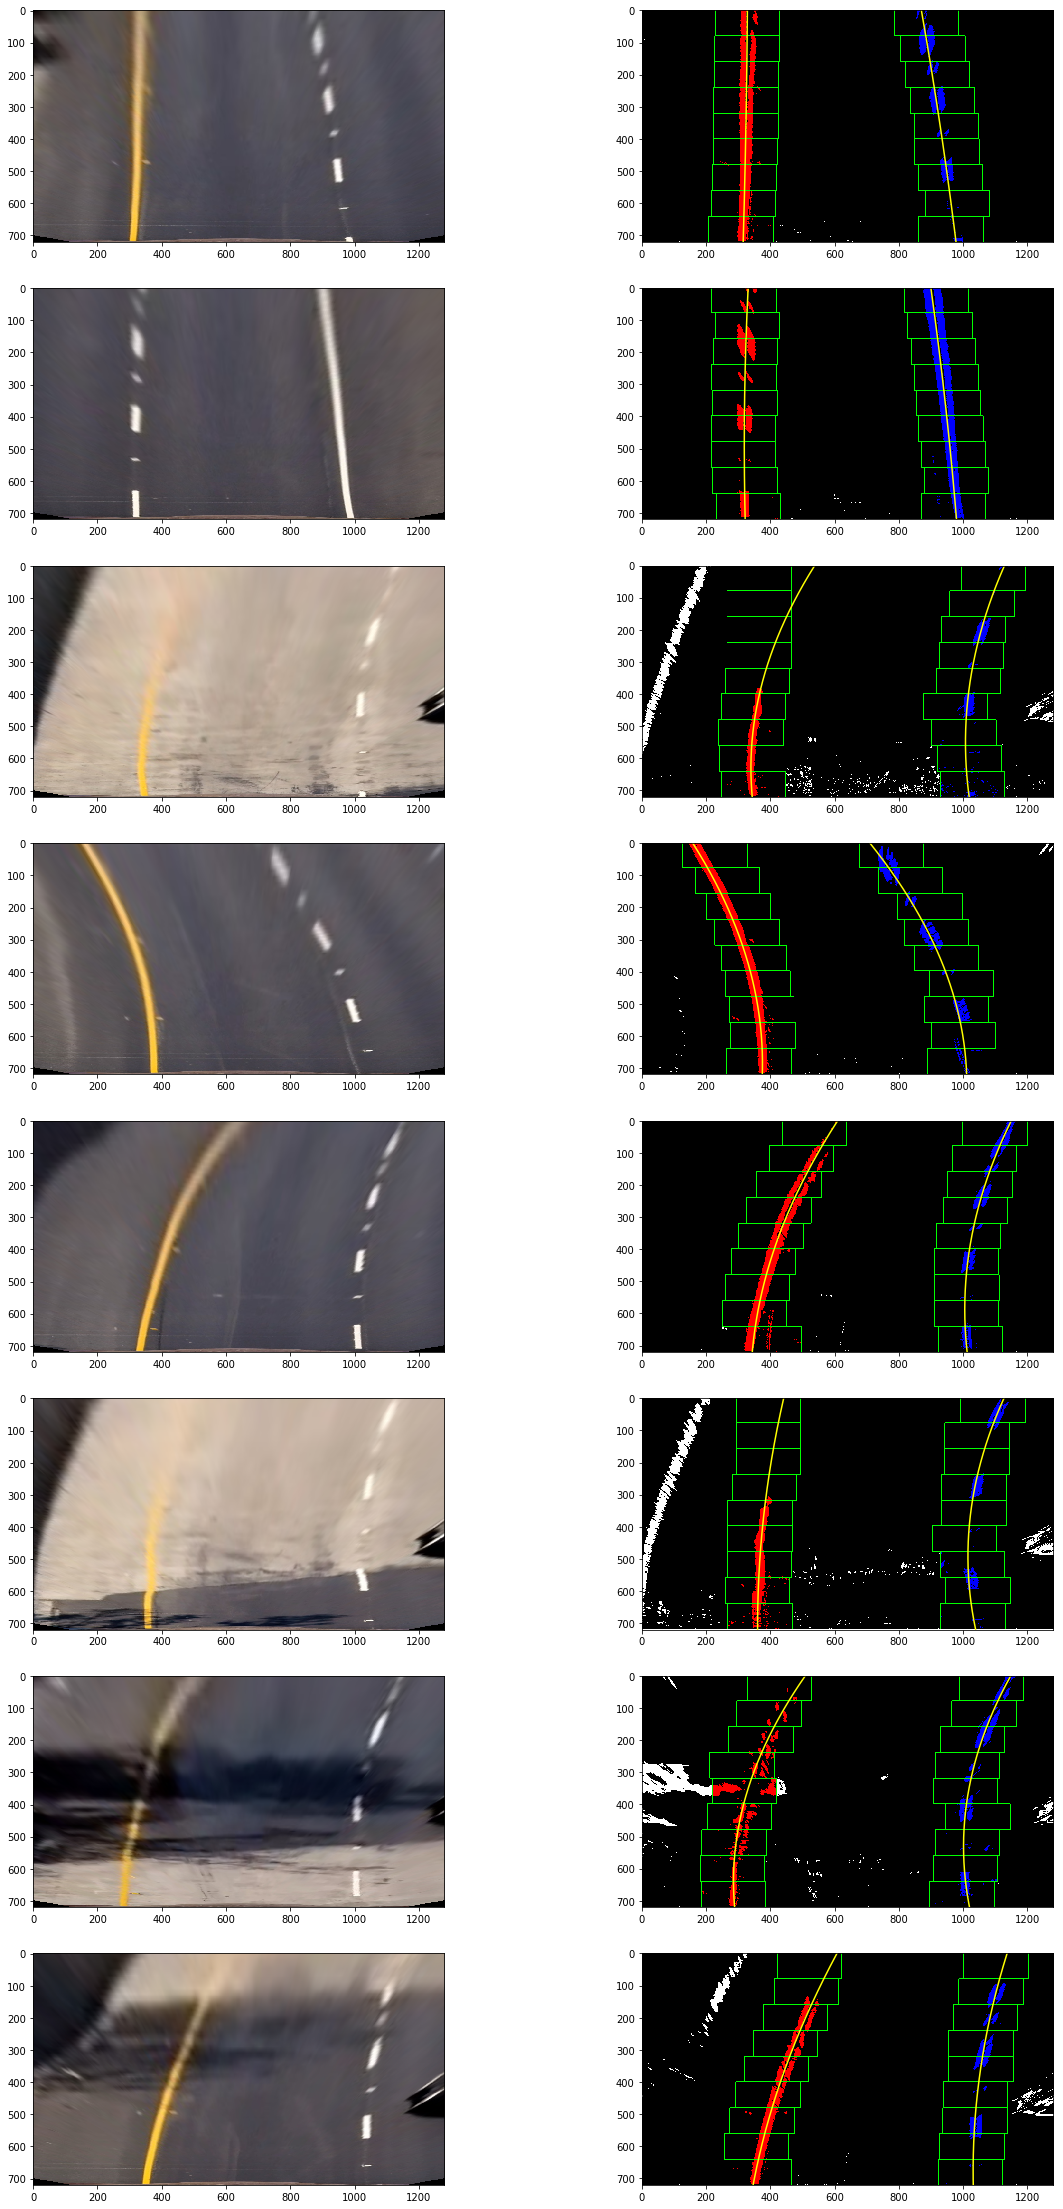

In [43]:
#find the line and get the line 
test_images=[
   './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg',   
]
f, axarr = plt.subplots(len(test_images), 2, figsize=(20, 5*len(test_images)))
for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    undist = lf.undistort(img)
    warped = lf.bird_eye_transform(undist)
    combined_binary = lf.combined_thresholding(warped)
    copy_combined_binary = np.copy(combined_binary)
    
    hist_left_fit, hist_right_fit, visualize_hist_search = lf.histogram_find_lines(
        copy_combined_binary, visualize=True)
    #left_fit, right_fit, visualize_conv_search = lf.convolution_find_lines(
    #    combined_binary, hist_left_fit, hist_right_fit, visualize=True)
    rgb_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    axarr[idx][0].imshow(rgb_warped)
    
    # plot naive_find_lines line
    ploty = np.linspace(0, lf.height-1, lf.height)
    hist_left_fitx = hist_left_fit[0]*ploty**2 + hist_left_fit[1]*ploty + hist_left_fit[2]
    hist_right_fitx = hist_right_fit[0]*ploty**2 + hist_right_fit[1]*ploty + hist_right_fit[2]
    
    axarr[idx][1].imshow(visualize_hist_search, cmap='gray')
    axarr[idx][1].plot(hist_left_fitx, ploty, color='yellow')
    axarr[idx][1].plot(hist_right_fitx, ploty, color='yellow')
    axarr[idx][1].set_xlim([0, 1280])
    axarr[idx][1].set_ylim([720, 0])
    
   